In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import time

# Define as cores para o terminal
BLUE = '\033[94m'
PURPLE = '\033[95m'
CYAN = '\033[96m'
GREEN = '\033[92m'
RED = '\033[91m'
YELLOW = '\033[93m'
ORANGE = '\033[33m'
BLACK_BG = '\033[40;37m'
END = '\033[0m'

# Printa, caso verbose=True, a mensagem com a cor e o tempo
def print_message(msg, color, clock=None, verbose=False):
    if verbose:
        clock = round(clock, 2) if clock > -1 else ''
        msg = f'{color}{clock} {msg}{END}' if clock else f'{color}{msg}{END}'
        print(msg)

# Classe para os eventos
class Event:
    def __init__(self, type_, timestamp, id):
        self.type_ = type_
        self.timestamp = timestamp
        self.id = id

    def __str__(self):
        return f'{self.type_} {self.id} {self.timestamp:.2f}'

## Filas M/M/1

In [2]:
CURRENT_ITERATION = 0

# Gerar tempo para o próximo evento
def generate_next(rate):
    return np.random.exponential(1 / rate)

# Simulação de fila M/M/1
def mm1_simulation(
    arrival_rate, service_rate, max_events, max_queue_len, verbose
):
    global CURRENT_ITERATION
    CURRENT_ITERATION += 1
    if verbose:
        print_message(f'Iteração #{CURRENT_ITERATION}', BLACK_BG, -1, verbose)
        print_message(
            # Junta as strings da lista com o separador ' | '
            ' | '.join([
                f'Chegada: {arrival_rate}',
                f'Partida: {service_rate}',
                f'Iterações: {max_events}',
                f'Tamanho máximo da fila: {max_queue_len}'
            ]),
            BLACK_BG, -1, verbose
        )

    L = []  # Lista de eventos (Fila de prioridades)
    N = 0  # Número de clientes na fila (variavel de estado)
    customer_number = 0

    # Cria um arquivo csv para armazenar os dados
    file_name = f'mm1_{time.time()}.csv'
    stacktrace = open(file_name, 'w')
    stacktrace.write('eType,N,clock\n')

    def schedule_event(type, timestamp):
        nonlocal customer_number  # Permite acesso à variável customer_number declarada fora da função
        event = Event(type, timestamp, customer_number)
        L.append(event)  # Adiciona evento
        L.sort(key=lambda x: x.timestamp) # Ordena fila por prioridade (timestamp)
        customer_number += 1  # Incrementa o número do cliente para o próximo evento

    # Simulação começa com chegada de cliente
    schedule_event('Arrival', generate_next(arrival_rate))

    # Plano de controle (enquanto a fila não estiver vazia e o número máximo de
    # iterações não for atingido)
    is_busy = True
    it = 0
    while len(L) > 0 and (customer_number < max_events or max_events == -1):
        it += 1
        e = L.pop(0)  # Remove evento e da fila (de prioridades) de eventos
        clock = e.timestamp  # Atualiza relógio

        # Sortear tempo da próxima chegada e agendar evento
        # Se N = 1, sortear tempo da próxima partida e agendar partida
        if e.type_ == 'Arrival':
            if max_queue_len == -1 or N < max_queue_len:
                schedule_event('Arrival', clock + generate_next(arrival_rate))
                N += 1
                print_message(f'Cliente chega (N = {N})', GREEN, clock, verbose)
                if N == 1:
                    schedule_event('Departure', clock + generate_next(service_rate))
            else:
                print_message(f'Cliente chega e desiste (N = {N})', RED, clock, verbose)

        # Se N > 0, sortear tempo da próxima partida e agendar partida
        if e.type_ == 'Departure':
            if N > 0:
                # Se servidor estava ocioso, servidor volta a atender
                if not is_busy:
                    print_message(f'Servidor volta a atender (N = {N})', CYAN, clock, verbose)
                N -= 1
                is_busy = True
                schedule_event('Departure', clock + generate_next(service_rate))
                print_message(f'Cliente sai (N = {N})', YELLOW, clock, verbose)

        stacktrace.write(f'{e.type_},{N},{clock}\n')

        # Se N = 0 e servidor estava ocupado, servidor fica ocioso
        if N == 0 and is_busy:
            print_message(f'Servidor fica ocioso (N = {N})', BLUE, clock, verbose)
            is_busy = False

        if max_events == -1 and it == 100000:
            break

    stacktrace.close()
    return file_name

def mm1_run_many(arrival_rate, service_rate, max_events, max_queue_len, i=2, verbose=False):
    counter = 0
    file_trace = []
    while counter < i:
        print(f'{PURPLE}Simulação #{counter + 1}{END}')
        file_trace.append(mm1_simulation(arrival_rate, service_rate, max_events, max_queue_len, verbose))
        counter += 1
    return file_trace

## Ruína do apostador

In [60]:
def gambler_ruin(lambda_, mi_, goal, starting_amount, infinity=False, verbose=False):
    p = lambda_ / (lambda_ + mi_)  # Probabilidade de ganhar
    q = mi_ / (lambda_ + mi_)  # Probabilidade de perder
    N = starting_amount  # Equivalente a primeira chegada
    round = 0  # Número de rodadas ("clock")

    # Cria um arquivo csv para armazenar os dados
    file_name = f'gambler_{time.time()}.csv'
    stacktrace = open(file_name, 'w')
    stacktrace.write('eType,N,clock\n')

    def schedule_event(p, timestamp):
        # Escolhe em um intervalo de 0 a 1 a propabilidade de escolher p ou q
        if np.random.rand() < p:
            return Event('Win', timestamp, 1)
        else:
            return Event('Lose', timestamp, -1)

    # Plano de controle (enquanto o apostador não atingir o objetivo ou falir)
    while (N > 0 and (N < goal or goal == -1)):
        round += 1
        event = schedule_event(p, round)
        N += event.id

        if event.type_ == 'Win':
            print_message(f'{round}: Jogador ganhou {event.id} | Montante: {N}', PURPLE, round, verbose)

        if event.type_ == 'Lose':
            print_message(f'{round}: Jogador perdeu {event.id} | Montante: {N}', BLUE, round, verbose)

        # Escreve no arquivo
        stacktrace.write(f'{event.type_},{N},{round}\n')

        # No modo de execucao infinito, sempre que o apostador falir, ele volta a ter 1 real
        if N == 0 and infinity:
            N = 1

        if infinity and round == 100000:
            break

    # Imprime resultado
    if N == goal:
        print_message(f'O apostador atingiu o objetivo de {goal} em {round} rodadas', GREEN, round, verbose)
    else:
        print_message(f'O apostador faliu em {round} rodadas', RED, round, verbose)

    stacktrace.close()
    return file_name

def gambler_run_many(lambda_, mi_, goal, starting_amount, i=2, verbose=False, infinity=False):
    counter = 0
    file_trace = []
    while counter < i:
        print(f'{PURPLE}Simulação #{counter + 1}{END}')
        file_trace.append(gambler_ruin(lambda_, mi_, goal, starting_amount, verbose=verbose, infinity=infinity))
        counter += 1
    return file_trace

In [4]:
# Calculos analiticos

# Calcula Ro
def calculaRo(lambda_, mu_):
    ro = lambda_ / mu_
    return ro

# Fracao de tempo que o sistema fica ocioso
def fracaoTempoSistemaOcioso(ro):
    pi_zero = 1 - ro
    return pi_zero

# Tamanho medio da fila
def tamanhoMedioFila(ro):
    Nq = (ro**2) / (1 - ro)
    return Nq

# Tempo medio do cliente no sistema
def tempoMedioClienteSistema(lambda_, N):
    wip = N / lambda_
    return wip

# Numero medio de clientes no sistema
def numeroMedioClientesSistema(ro):
    e_N = ro / (1 - ro)
    return e_N

def calcAnalitica(lambda_, mu_):
    ro = calculaRo(lambda_, mu_)
    e_N = numeroMedioClientesSistema(ro)
    e_W = tempoMedioClienteSistema(lambda_, e_N)
    return e_N, e_W

In [14]:
# Temos que calcular:
#   E_N = Média do numero de clientes no sistema
#   W = Tempo médio de espera de cada cliente no sistema
#   CDF(E_N)
#   CDF(W)

N_ITERR = 5000

def calculadoraSimulacao(file_list, cdf=False):
    arr_e_N , arr_e_W = [], []
    arr_cdf_e_N = []
    arr_cdf_e_W = []
    arr_frac_ocioso = []
    for sim_file in file_list:
        file = open(sim_file, 'r')
        # Drop da primeira linha
        file.readline()
        # Inicializa variaveis
        iterr, arrivals, services = 0, 0, 0
        apx_lambda, apx_mu = 0, 0
        pi_zero = 0 # Fração de tempo que o sistema fica ocioso
        act_n, act_clock , acumm_n = 0, 0, 0
        ant_n, ant_clock = act_n, act_clock
        arr_e_N_sim_act, arr_e_W_sim_act = [], []
        arr_t_ocioso = []
        num_vzs_n = {}

        for line in file.readlines():
            iterr += 1
            eType, act_n, act_clock = line.split(',')
            # Converte str para int e float
            act_n, act_clock = int(act_n), float(act_clock)
            # Soma o acumulador do número total de clientes no sistema
            acumm_n += act_n
            # Calcula o número médio de clientes no sistema
            e_N = acumm_n / iterr

            # Para a CDF de E_N
            # Se a chave não existe, cria ela com valor 1
            # Se a chave existe, soma 1 ao valor
            num_vzs_n[act_n] = 1 if (act_n not in num_vzs_n) else num_vzs_n[act_n] + 1

            if eType == 'Arrival' or eType == 'Win':
                arrivals += 1 # Soma mais uma chegada
                apx_lambda = arrivals / act_clock # Aproximação de lambda
            else:
                services += 1 # Soma mais uma partida
                # Se o sistema estava vazio e continua vazio, então está ocioso
                if (ant_n == 0):
                    # Soma o tempo que o sistema ficou ocioso
                    pi_zero += act_clock - ant_clock
                    # Fração de tempo que o sistema fica ocioso
                    arr_t_ocioso.append(pi_zero / act_clock)

            # Calcula o tempo médio de espera de cada cliente no sistema
            wip = (e_N + 0.05) / (apx_lambda + 0.05)


            # Atualiza variáveis anteriores para a próxima iteração
            ant_n, ant_clock = act_n, act_clock

            # Adiciona os valores calculados nas listas de cada simulação
            arr_e_N_sim_act.append(e_N)
            arr_e_W_sim_act.append(wip)

        if cdf:
            # Com o dicionário completo, temos o número de vezes que cada
            # número de clientes no sistema apareceu (número de vezes que
            # alcançou aquele estado) e, assim, podemos calcular a CDF
            # A CDF representa a probabilidade de o sistema estar em um
            # determinado estado ou em um estado menor que ele
            cdf_e_N = np.zeros(len(num_vzs_n))

            for i in range(len(cdf_e_N)):
                for j in range(i + 1):
                    cdf_e_N[i] += num_vzs_n[j]
                cdf_e_N[i] /= sum(num_vzs_n.values())

            cdf_e_W = np.zeros(len(arr_e_W_sim_act))

            for i in range(len(cdf_e_W)):
                for j in range(i + 1):
                    cdf_e_W[i] += arr_e_W_sim_act[j]
                cdf_e_W[i] /= sum(arr_e_W_sim_act)

            arr_cdf_e_N.append(cdf_e_N)
            arr_cdf_e_W.append(cdf_e_W)

        # Adiciona as listas de cada simulação nas listas de todas as simulações
        arr_e_N.append(arr_e_N_sim_act)
        arr_e_W.append(arr_e_W_sim_act)
        arr_frac_ocioso.append(arr_t_ocioso)

    # Encontra o menor número de observações entre todas as simulações
    n_sim = len(file_list)
    min_obs_E_N = min([len(obs) for obs in arr_e_N])
    min_obs_W = min([len(obs) for obs in arr_e_W])
    min_ons_ocioso = min([len(obs) for obs in arr_frac_ocioso])
    if cdf:
        min_obs_cdf_e_N = min([len(obs) for obs in arr_cdf_e_N])
        min_obs_cdf_e_W = min([len(obs) for obs in arr_cdf_e_W])

    # Calcula a média de e_N e e_W entre todas as simulações
    mean_E_N = [np.mean([arr_e_N[j][i] for j in range(n_sim)]) for i in range(min_obs_E_N)]
    mean_W = [np.mean([arr_e_W[j][i] for j in range(n_sim)]) for i in range(min_obs_W)]
    if cdf:
        mean_cdf_e_N = [np.mean([arr_cdf_e_N[j][i] for j in range(n_sim)]) for i in range(min_obs_cdf_e_N)]
        mean_cdf_e_W = [np.mean([arr_cdf_e_W[j][i] for j in range(n_sim)]) for i in range(min_obs_cdf_e_W)]
    else:
        mean_cdf_e_N, mean_cdf_e_W = None, None
    mean_prob_ocioso = [np.mean([arr_frac_ocioso[j][i] for j in range(n_sim)]) for i in range(min_ons_ocioso)]

    return mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso

In [26]:
def plotar_grafico_media(
    medias,
    linha_constante=None,
    titulo=None,
    nome_eixo_x=None,
    nome_eixo_y=None
):
    # Configurações do gráfico
    # Muda o tamanho da figura
    plt.figure(figsize=(12, 4))
    # Adiciona título
    plt.title(titulo)
    # Adiciona nome ao eixo x
    plt.xlabel(nome_eixo_x)
    # Adiciona nome ao eixo y
    plt.ylabel(nome_eixo_y)

    # Criar uma lista com os valores de iteração
    iteracao = list(range(1, len(medias) + 1))

    # Plotar o gráfico para as médias dos clientes
    plt.plot(iteracao, medias, label=nome_eixo_y)

    # Adicionar uma linha constante no eixo y, se fornecida
    if linha_constante is not None:
        # Adicionar a linha constante no gráfico
        plt.axhline(
            linha_constante, color='red', linestyle='dashed', linewidth=2,
            label=f'Valor previsto ({linha_constante})'
        )

    # Mostra o gráfico
    plt.legend()
    plt.show()

def plotar_grafico_media_com_intervalo_confianca(
    medias,
    linha_constante=None,
    confianca=0.95,
    titulo=None,
    nome_eixo_x=None,
    nome_eixo_y=None
):
    # Configurações do gráfico
    # Muda o tamanho da figura
    plt.figure(figsize=(12, 4))
    # Adiciona título
    plt.title(titulo)
    # Adiciona nome ao eixo x
    plt.xlabel(nome_eixo_x)
    # Adiciona nome ao eixo y
    plt.ylabel(nome_eixo_y)

    # Calcular o intervalo de confiança para cada valor de medias
    intervalos_confianca = [stats.t.interval(
        confianca, len(medias) - 1, loc=media, scale=stats.sem(medias)
    ) for media in medias]

    # Extrair os limites inferior e superior de cada intervalo de confiança
    inferior, superior = zip(*intervalos_confianca)

    # Criar uma lista com os valores de iteração
    iteracao = list(range(1, len(medias) + 1))

    # Plotar o gráfico para as médias dos clientes
    plt.plot(iteracao, medias, label=nome_eixo_y)
    plt.fill_between(
        iteracao, inferior, superior, alpha=0.2, color='black',
        label=f'Intervalo de Confiança - {nome_eixo_y} ({confianca*100:.0f}%)'
    )

    # Adicionar uma linha constante no eixo y, se fornecida
    if linha_constante is not None:
        # Adicionar a linha constante no gráfico
        plt.axhline(
            linha_constante, color='red', linestyle='dashed', linewidth=2,
            label=f'Valor previsto ({linha_constante})'
        )

    # Mostra o gráfico
    plt.legend()
    plt.show()

def plota_grafico_cdf(mean_cdf, lamda_, onlyAnalitic=False):
    # Valores de x para o gráfico da CDF
    x_analitico = np.linspace(0, len(mean_cdf) + 1, (len(mean_cdf) + 1) + 10)

    # Calcula a CDF analítica
    cdf_analitica = 1 - np.exp(-lamda_ * x_analitico)

    # Prepara a entrada do plor da CDF discreta
    x = np.arange(len(mean_cdf))
    y = mean_cdf

    # Plotar o gráfico da CDF discreta e da CDF analítica
    plt.figure(figsize=(10, 5))
    if not onlyAnalitic:
        plt.plot(x, y, 'o', label='Pontos da CDF')
        plt.plot(x, y, drawstyle='steps-post', label='CDF discreta')
    plt.plot(x_analitico, cdf_analitica, label='CDF Analítica')
    plt.title('CDF')
    plt.xlabel('N')
    plt.ylabel('CDF')
    plt.legend()
    plt.show()

### Caso 1 M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


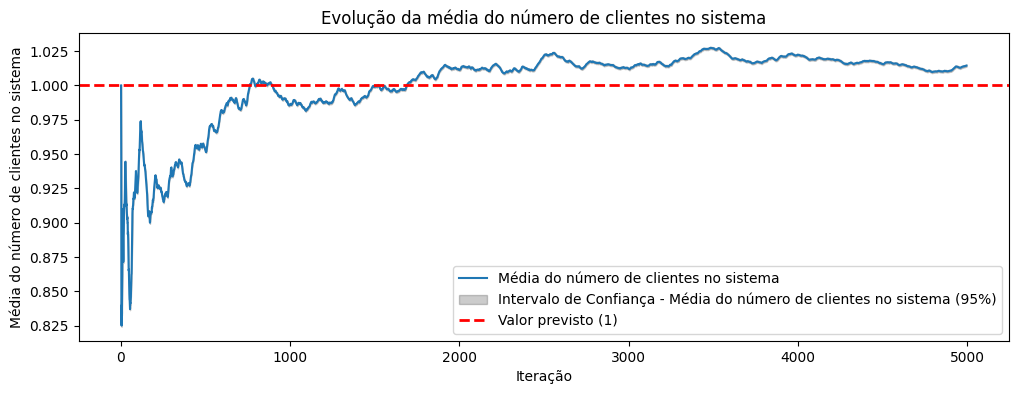

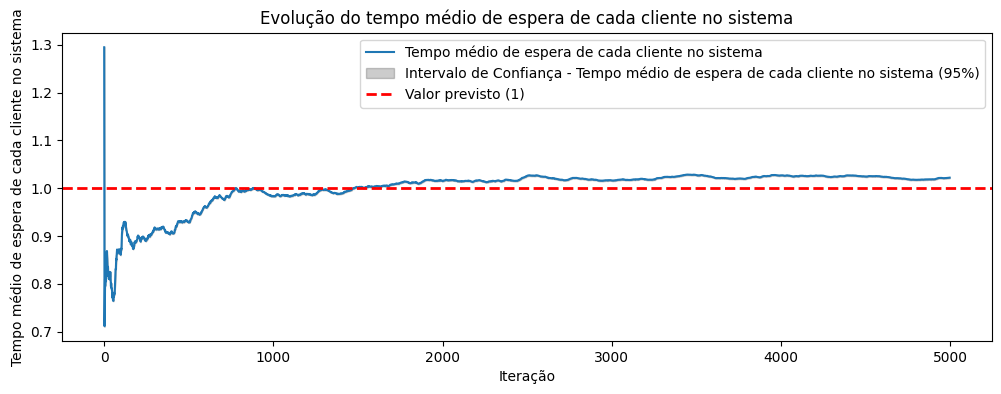

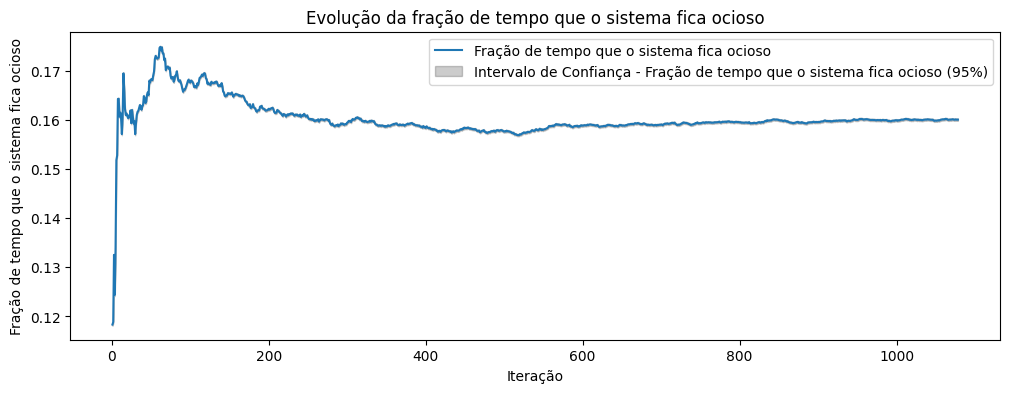

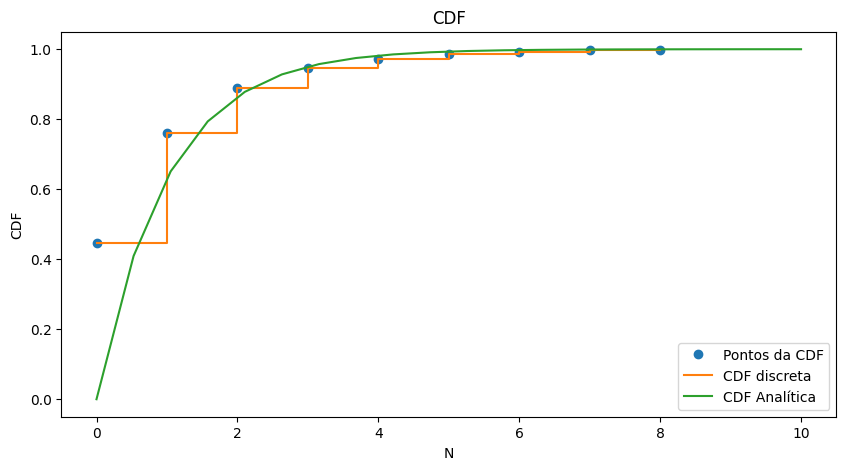

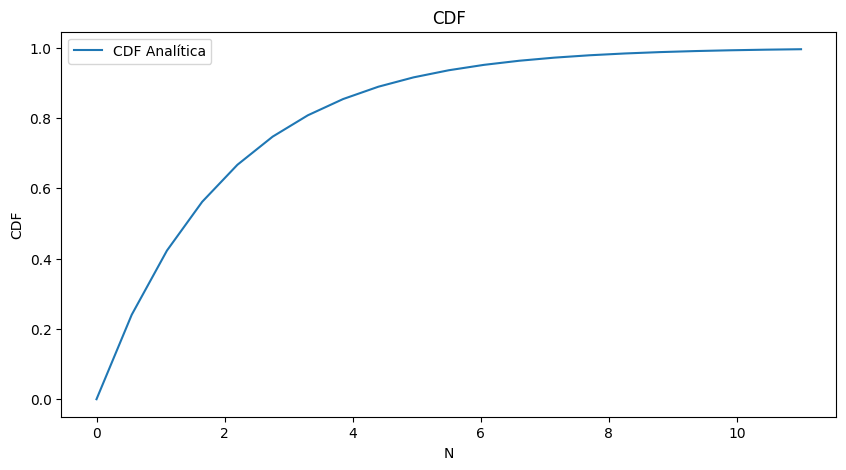

In [7]:
lambda_, mu_ = 1, 2
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, -1, 20), cdf=True)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, linha_constante=1, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, linha_constante=1, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_prob_ocioso, titulo='Evolução da fração de tempo que o sistema fica ocioso', nome_eixo_x='Iteração', nome_eixo_y='Fração de tempo que o sistema fica ocioso')
plota_grafico_cdf(mean_cdf_e_N, lambda_)
plota_grafico_cdf(np.zeros(10), lambda_ / mu_, onlyAnalitic=True)

### Caso 2 M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


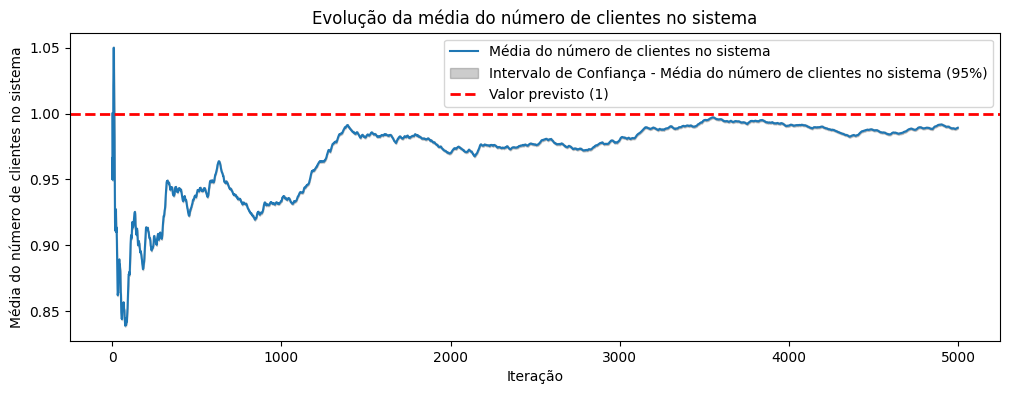

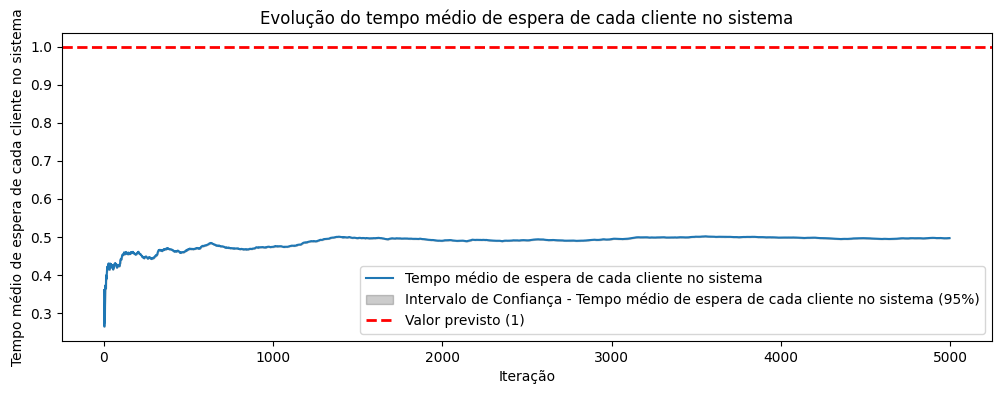

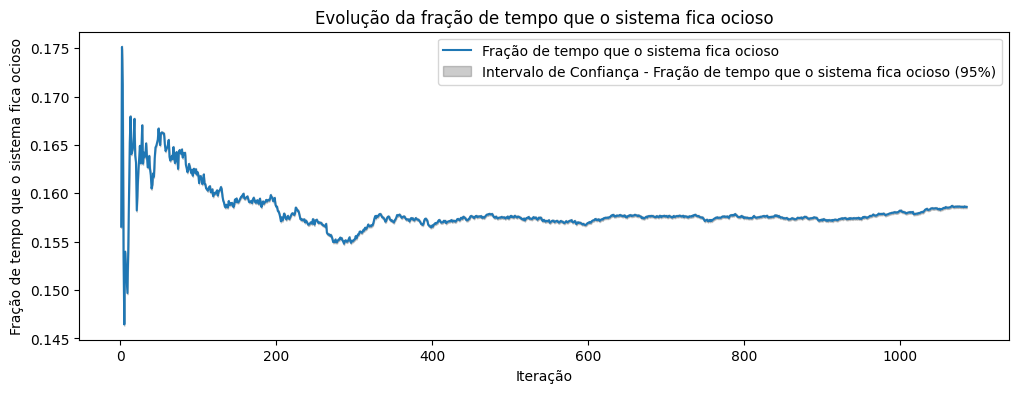

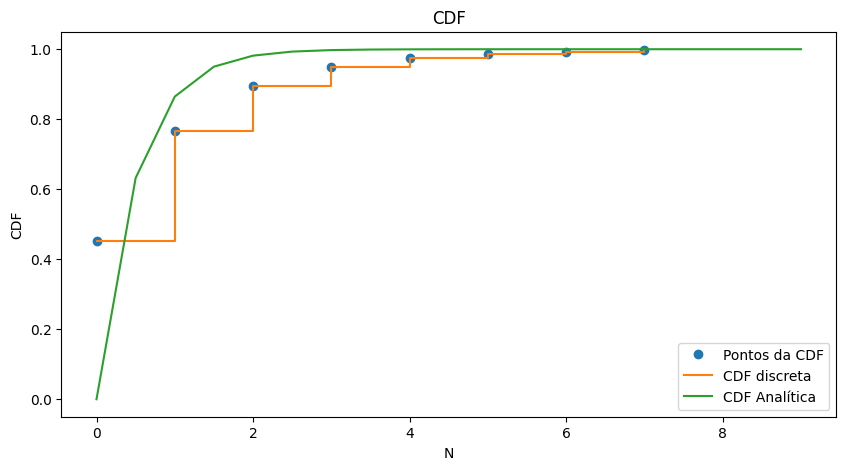

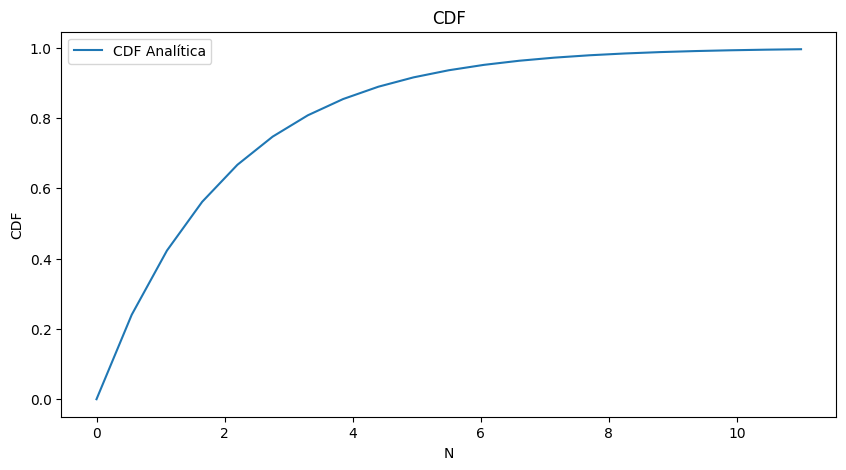

In [8]:
lambda_, mu_ = 2, 4
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, -1, 20), cdf=True)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, linha_constante=1, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, linha_constante=1, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_prob_ocioso, titulo='Evolução da fração de tempo que o sistema fica ocioso', nome_eixo_x='Iteração', nome_eixo_y='Fração de tempo que o sistema fica ocioso')
plota_grafico_cdf(mean_cdf_e_N, lambda_)
plota_grafico_cdf(np.zeros(10), lambda_ / mu_, onlyAnalitic=True)

### Caso 3 M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


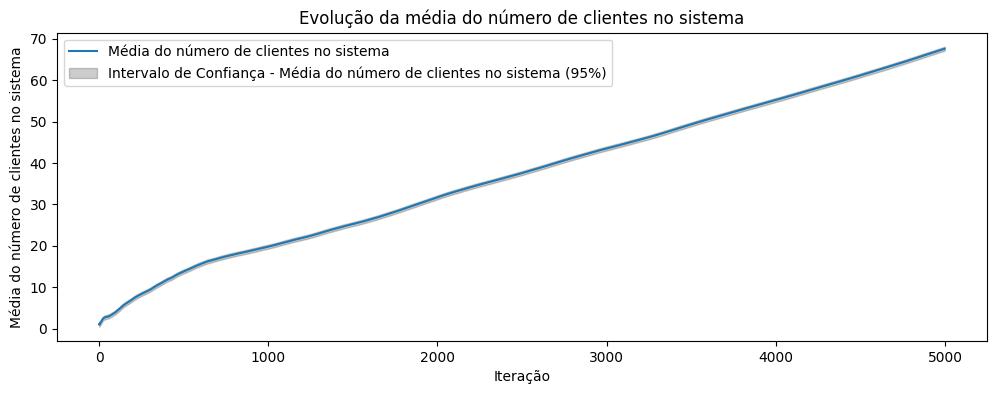

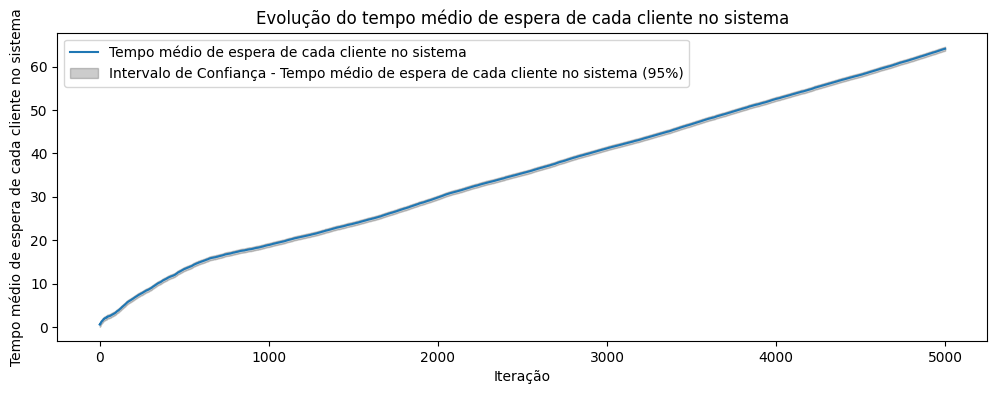

O sistema não ficou ocioso


In [10]:
lambda_, mu_ = 1.05, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, -1, 20), cdf=False)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media_com_intervalo_confianca(mean_prob_ocioso, titulo='Evolução da fração de tempo que o sistema fica ocioso', nome_eixo_x='Iteração', nome_eixo_y='Fração de tempo que o sistema fica ocioso')
else:
    print('O sistema não ficou ocioso')

### Caso 4 M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


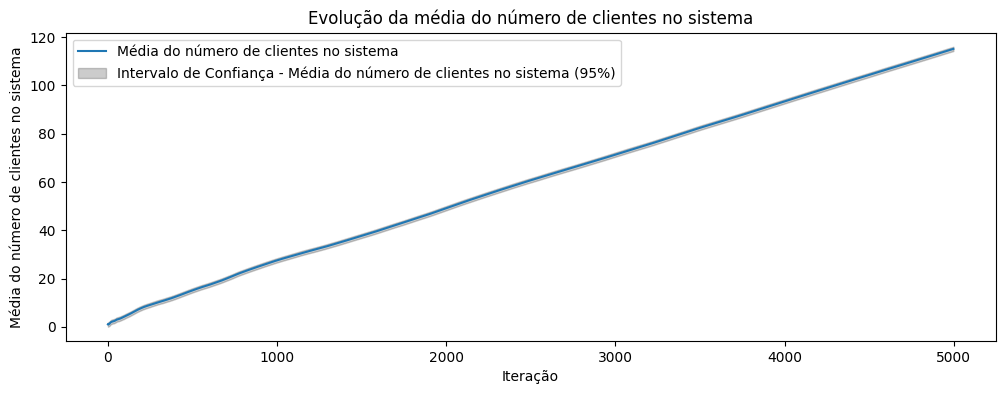

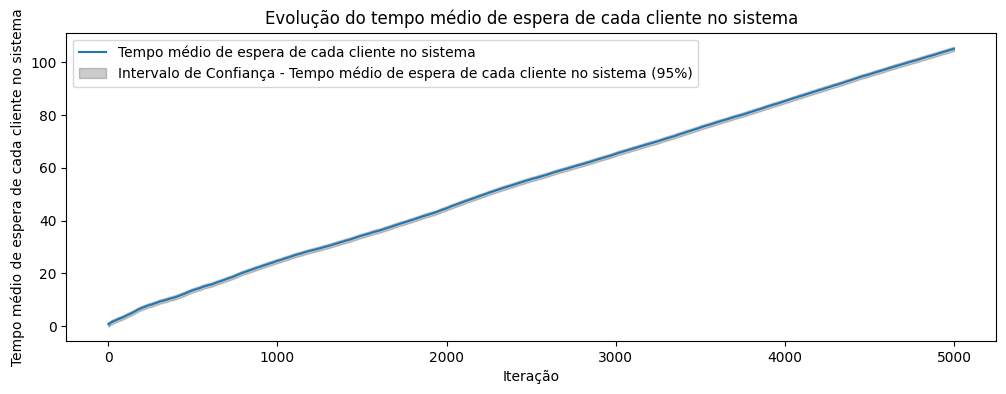

O sistema não ficou ocioso


In [11]:
lambda_, mu_ = 1.10, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, -1, 20), cdf=False)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media_com_intervalo_confianca(mean_prob_ocioso, titulo='Evolução da fração de tempo que o sistema fica ocioso', nome_eixo_x='Iteração', nome_eixo_y='Fração de tempo que o sistema fica ocioso')
else:
    print('O sistema não ficou ocioso')

### Caso 3 Ruína

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5


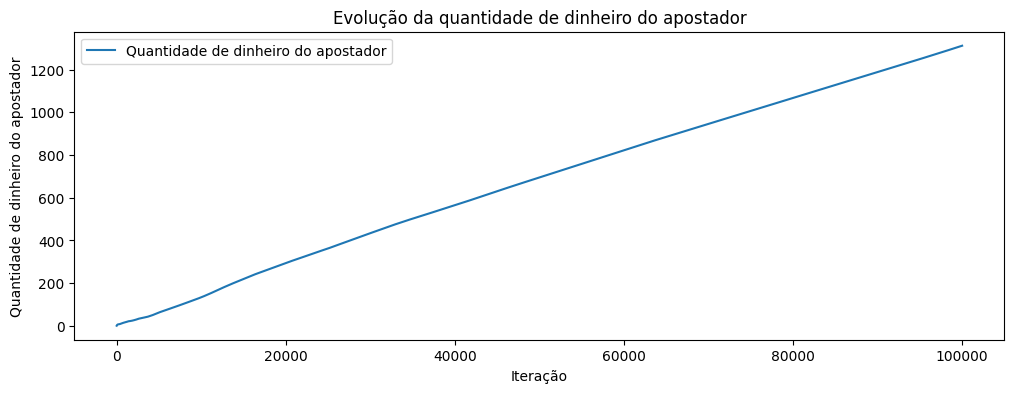

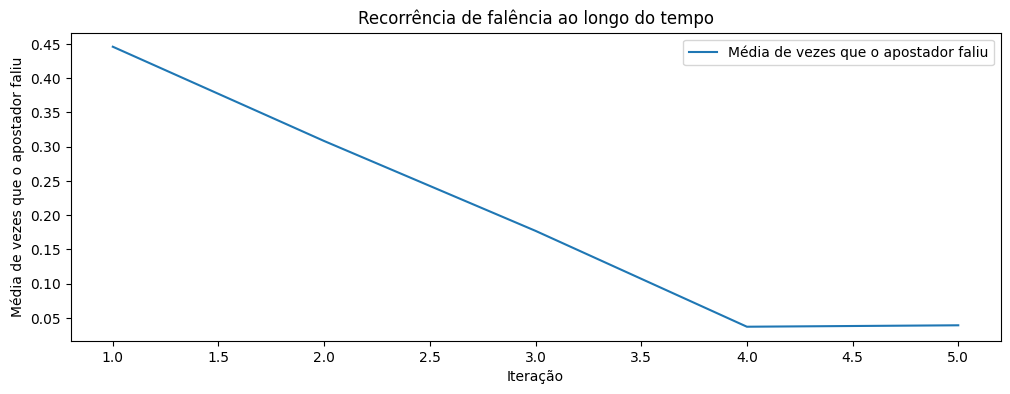

In [64]:
lambda_, mu_ = 1.05, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso  = calculadoraSimulacao(gambler_run_many(lambda_, mu_, -1, 1, i=5, infinity=True), cdf=False)
plotar_grafico_media(mean_E_N, titulo='Evolução da quantidade de dinheiro do apostador', nome_eixo_x='Iteração', nome_eixo_y='Quantidade de dinheiro do apostador')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media(mean_prob_ocioso, titulo='Recorrência de falência ao longo do tempo', nome_eixo_x='Iteração', nome_eixo_y='Média de vezes que o apostador faliu')
else:
    print('O apostador não faliu')


### Caso 4 Ruína

Simulação #1


Simulação #2
Simulação #3
Simulação #4
Simulação #5


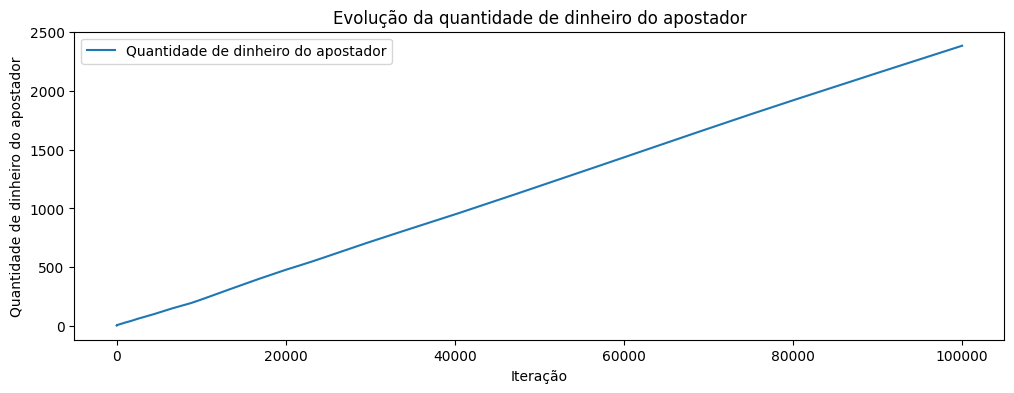

O apostador não faliu


In [65]:
lambda_, mu_ = 1.10, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso  = calculadoraSimulacao(gambler_run_many(lambda_, mu_, -1, 1, i=5, infinity=True), cdf=False)
plotar_grafico_media(mean_E_N, titulo='Evolução da quantidade de dinheiro do apostador', nome_eixo_x='Iteração', nome_eixo_y='Quantidade de dinheiro do apostador')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media(mean_prob_ocioso, titulo='Recorrência de falência ao longo do tempo', nome_eixo_x='Iteração', nome_eixo_y='Média de vezes que o apostador faliu')
else:
    print('O apostador não faliu')

### Caso 3 Finito M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


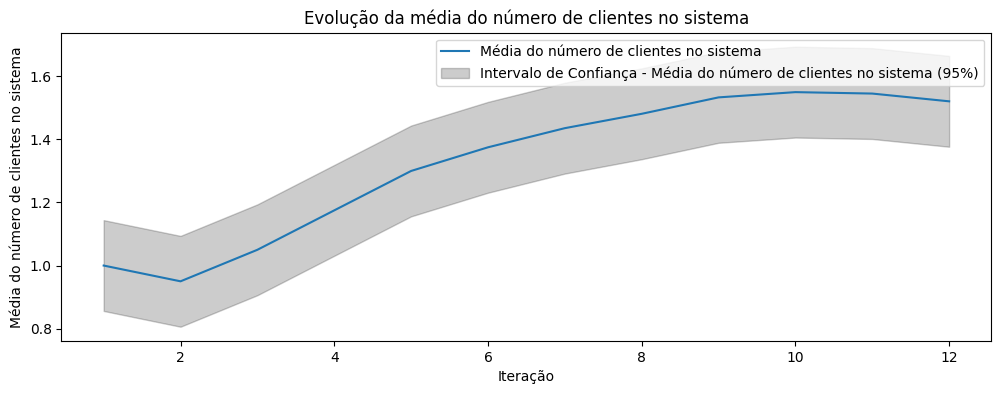

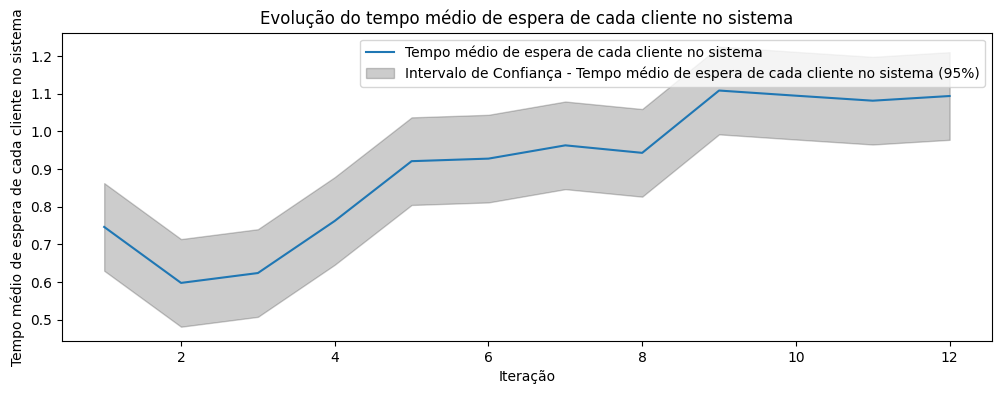

In [38]:
lambda_, mu_ = 1.05, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, 5, 20), cdf=False)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')

### Caso 3 Finito Ruína

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


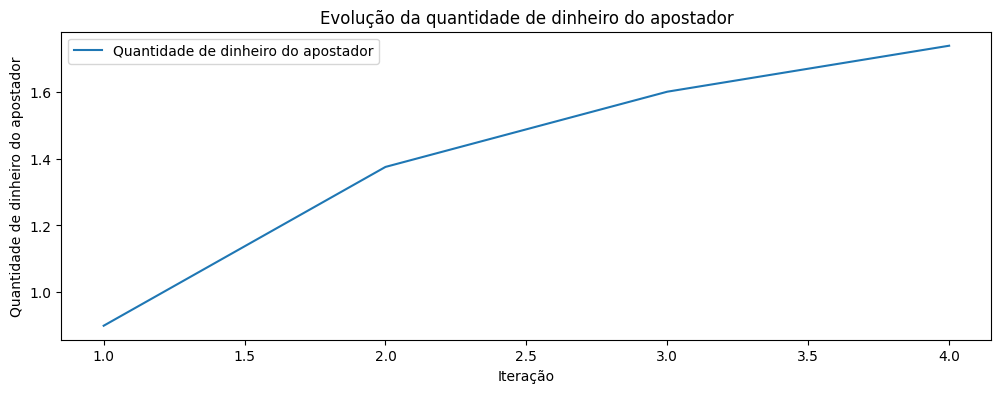

O apostador não faliu


In [62]:
lambda_, mu_ = 1.05, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso  = calculadoraSimulacao(gambler_run_many(lambda_, mu_, 5, 1, i=20, infinity=True), cdf=False)
plotar_grafico_media(mean_E_N, titulo='Evolução da quantidade de dinheiro do apostador', nome_eixo_x='Iteração', nome_eixo_y='Quantidade de dinheiro do apostador')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media(mean_prob_ocioso, titulo='Recorrência de falência ao longo do tempo', nome_eixo_x='Iteração', nome_eixo_y='Média de vezes que o apostador faliu')
else:
    print('O apostador não faliu')


### Caso 4 Finito M/M/1

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


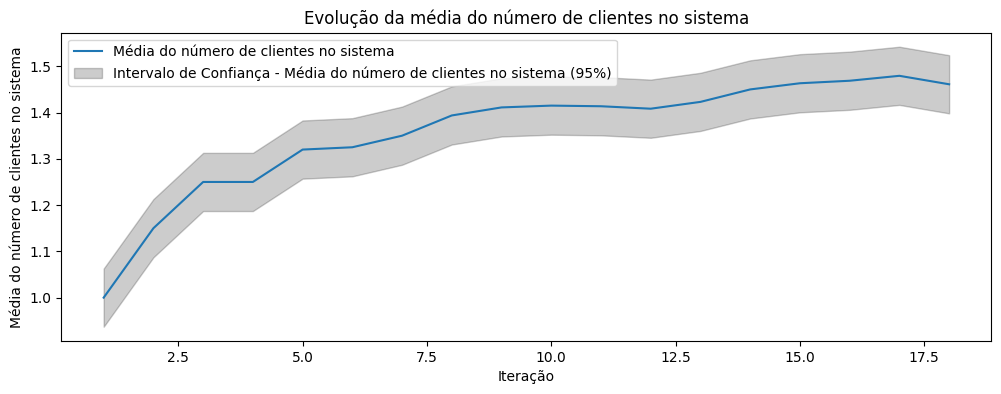

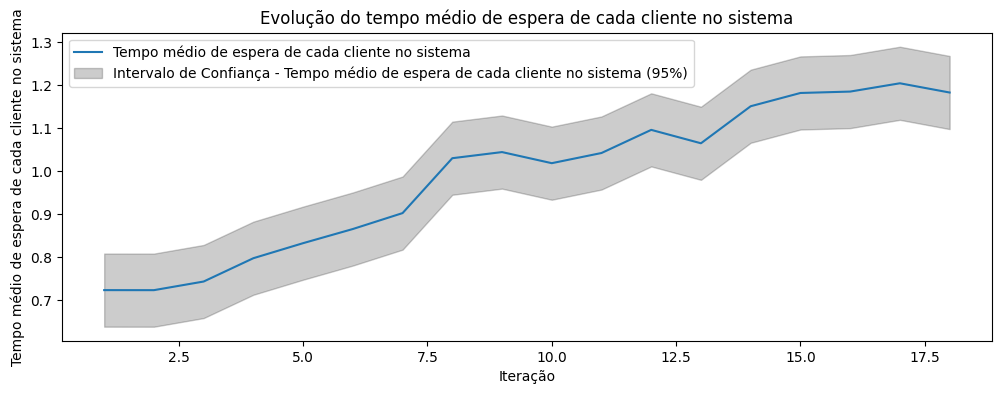

In [66]:
lambda_, mu_ = 1.10, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso = calculadoraSimulacao(mm1_run_many(lambda_, mu_, N_ITERR, 5, 20), cdf=False)
plotar_grafico_media_com_intervalo_confianca(mean_E_N, titulo='Evolução da média do número de clientes no sistema', nome_eixo_x='Iteração', nome_eixo_y='Média do número de clientes no sistema')
plotar_grafico_media_com_intervalo_confianca(mean_W, titulo='Evolução do tempo médio de espera de cada cliente no sistema', nome_eixo_x='Iteração', nome_eixo_y='Tempo médio de espera de cada cliente no sistema')

### Caso 4 Finito Ruina

Simulação #1
Simulação #2
Simulação #3
Simulação #4
Simulação #5
Simulação #6
Simulação #7
Simulação #8
Simulação #9
Simulação #10
Simulação #11
Simulação #12
Simulação #13
Simulação #14
Simulação #15
Simulação #16
Simulação #17
Simulação #18
Simulação #19
Simulação #20


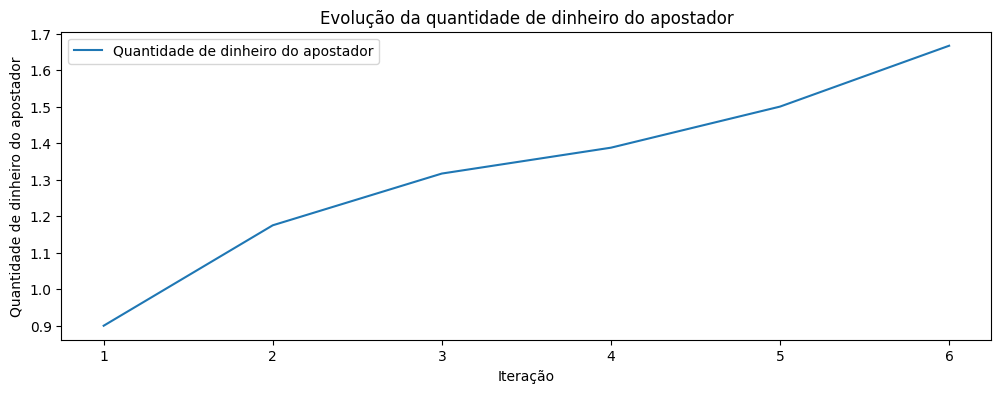

O apostador não faliu


In [67]:
lambda_, mu_ = 1.10, 1
mean_E_N, mean_W, mean_cdf_e_N, mean_cdf_e_W, mean_prob_ocioso  = calculadoraSimulacao(gambler_run_many(lambda_, mu_, 5, 1, i=20, infinity=True), cdf=False)
plotar_grafico_media(mean_E_N, titulo='Evolução da quantidade de dinheiro do apostador', nome_eixo_x='Iteração', nome_eixo_y='Quantidade de dinheiro do apostador')
if len(mean_prob_ocioso) > 0:
    plotar_grafico_media(mean_prob_ocioso, titulo='Recorrência de falência ao longo do tempo', nome_eixo_x='Iteração', nome_eixo_y='Média de vezes que o apostador faliu')
else:
    print('O apostador não faliu')
